In [1]:
import numpy as np
from sklearn import datasets

from NPIR import NPIR
import pandas as pd
from sklearn.datasets import make_blobs
import datetime
import warnings
from sklearn import metrics
from collections import Counter as Cs
from timeit import default_timer as timer
from datetime import timedelta
import matplotlib.pyplot as plt


import findspark
findspark.init()
from pyspark import SparkContext
from operator import *
from pyspark import StorageLevel

from pyspark.sql.types import IntegerType, FloatType, BooleanType, StringType, StructType,\
StructField,ArrayType, DataType
from pyspark.sql.functions import udf, log, rand, monotonically_increasing_id, col, broadcast,\
greatest,desc,asc, row_number, avg, mean, least, struct, lit, sequence
from functools import reduce

import pyspark.sql.functions as F

from pyspark.sql import SparkSession, SQLContext, Window, Row, DataFrame
from pyspark import SparkConf

In [2]:
spark = SparkSession.builder.master("local[*]").config("spark.sql.broadcastTimeout", "30000s").\
config("spark.network.timeout","30000s").config("spark.executor.heartbeatInterval","12000000ms").\
config("spark.storage.blockManagerSlaveTimeoutMs","12000001ms").config("spark.driver.maxResultSize","4g").\
config("spark.default.parallelism", "100").config("spark.memory.offHeap.enabled","true").\
config("spark.memory.offHeap.size", "4g").appName("NPIR_Parallel").getOrCreate()

In [2]:
spark = SparkSession.builder.master("local[*]").appName("NPIR_Parallel").getOrCreate()

In [3]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [4]:
dt,lbl = make_blobs(n_samples=1500, centers=3,n_features=2, random_state=100)
data_df = pd.DataFrame(dt)
data_df.to_csv('blobs.csv')


In [6]:
data_spark_df = spark.read.format('csv').option('header','False').option('index','False').load('blobs.csv')
data_spark_df.count()

1500

In [7]:
#data_spark_df.select('_c0').show()

In [8]:
data_spark_df.describe()

DataFrame[summary: string, _c0: string, _c1: string, _c2: string]

In [9]:
#data_spark_df.show()

In [10]:
data_spark_df = data_spark_df.select('_c1', '_c2')

In [11]:
#data_spark_df.show()

In [12]:
new_name = ['first', 'second']
data_spark_rdd = data_spark_df.toDF(*new_name).rdd.filter(lambda x:x)
data_spark_df = data_spark_df.toDF(*new_name)

In [13]:
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)
spark.conf.set('spark.jars.packages','com.databricks:spark-cav_2.11')
spark.conf.set("spark.sql.parquet.compression.codec","gzip")
spark.conf.set("spark.sql.execution.arrow.enabled", "False")
sqlContext.setConf("spark.sql.shuffle.partitions", "10")

In [14]:
points = data_spark_df.count()
points

1500

In [15]:
#data_spark_df.show()

In [16]:
#IR: The indexing ratio to be used for generating the maximum index
IR = 0.2
#The number of iteration i
i = 5
k = 3 #k: Number of clusters
# count = Cs()
chunk = 300

In [17]:
data_spark_df

DataFrame[first: string, second: string]

In [18]:
from pyspark.sql.functions import desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window

data_spark = data_spark_df.withColumn('index_column_name', row_number().\
                                          over(Window.orderBy(monotonically_increasing_id())) - 1)
#data_spark.show()

In [19]:
def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

In [20]:
leaderheadr = ['chunkLabel', 'old label']
leaderheadr.extend([str(x) for x in range(1, len(data_spark.columns))])
leaderheadr = tuple(leaderheadr)
leaderheadr

('chunkLabel', 'old label', '1', '2')

In [21]:
labelsheader = ('chunkLabel', 'label')
labelsheader

('chunkLabel', 'label')

In [22]:
#data_spark_df.show()

In [23]:
#data_spark.show()

In [24]:
labels = sqlContext.createDataFrame([np.full(len(labelsheader), np.nan).tolist()],labelsheader)
labels = labels.na.drop()
#labels.show()
leaders = sqlContext.createDataFrame([np.full(len(leaderheadr), np.nan).tolist()],leaderheadr)
leaders = leaders.na.drop()
#leaders.show()


In [25]:
data_spark.count()

1500

In [26]:
#data_spark1 = data_spark.filter(col('index_column_name') < chunk )
#data_spark1.count()

In [27]:
#data_spark2 = data_spark.filter(col('index_column_name') >= chunk ).filter(col('index_column_name') < 2*chunk)
#data_spark2.count()

In [28]:
#data_spark3 = data_spark.filter(col('index_column_name') >= 2*chunk )
#data_spark3.count()

In [29]:
ii = 0
for z in range(0, points, chunk):
    j = z + chunk
    data = data_spark.where(col("index_column_name").between(z, j-1)).toPandas()
    data.drop("index_column_name",axis=1,inplace=True)
    data = data.astype(float)
    from NPIR import NPIR
    
    label = NPIR(data.values,k,IR,i)
    data['labels'] = label
    
    # Adding to pyspard label
    chunklabel = np.full(len(label), ii).tolist()
    #ii+=1
    labelDF = [(x, y) for x, y in zip(chunklabel, label)]
    labelsDF = sqlContext.createDataFrame(labelDF,labelsheader)
    labels = unionAll(labels, labelsDF)

    leader = []
    f = list(Cs(label))
    f.sort()
    for i in f:
        leader.append([round(np.mean(z), 4) for z in data[data['labels']==i].values[:,:-1].T])
    del data
    del NPIR
    
    # Adding to pyspark leaders
    for x in range(len(leader)):
        x1 = [ii, x]
        
        x1.extend(leader[x])
        leader[x] = x1
        
    leaderDF = sqlContext.createDataFrame(leader,leaderheadr)
    leaders = unionAll(leaders, leaderDF)
    ii += 1

In [30]:
#leaders.count()

In [31]:
data_spark = leaders.withColumn("first_numeric", leaders["1"].cast(FloatType()))
data_spark = data_spark.withColumn("second_numeric", data_spark["2"].cast(FloatType()))
data_spark = data_spark.drop('1').drop('2').drop('chunkLabel').drop('old label')
data_spark = data_spark.drop('1').drop('2').drop('chunkLabel').drop('old label')
# data_spadf

In [32]:
def MyCheckUpdate(a, b, c, d):
    a = float(a)
    b = float(b)
    c = float(c)
    d = float(d)
    res = (a-c) + (b-d)
    if res == 0:
        return 1.0
    return 0.0

check_centroid = udf(lambda x,y,z,r: MyCheckUpdate(x,y,z,r), FloatType())

def squaree1(c,u,f,g):
    c = float(c)
    u = float(u)
    f = float(f)
    g = float(g)
    array1 = np.array([c,u])
    array2 = np.array([f,g])
    dist = np.linalg.norm(array1-array2)
    dist = dist.item()
    return dist

squaree_spark1 = udf(lambda x,y,z,r: squaree1(x,y,z,r), FloatType())
sqlContext.sql("SET spark.sql.autoBroadcastJoinThreshold = -1")

DataFrame[key: string, value: string]

In [33]:
#data_cent = data_spark.join(broadcast(df_centroid))

In [34]:
df_centroid = data_spark.sample(False, 0.4,seed = 0).limit(1).cache()

new_name = ['x','y']
df_centroid = df_centroid.toDF(*new_name)

#just for first round
#first time
i = 0
data_cent = data_spark.join(broadcast(df_centroid))
data_cent1 = data_cent.withColumn(str(i),squaree_spark1(data_cent.columns[0],data_cent.columns[1],
                                              data_cent.columns[2*i+2],data_cent.columns[2*i+3]))
data_cent2 = data_cent1.drop(data_cent1.columns[i+2]).drop(data_cent1.columns[i+3])
data_cent3 = data_cent2.withColumn('mindist',col(str(i)))
data_cent4 = data_cent3.withColumn('mindist1',least(data_cent3.columns[i+2], col('mindist')))
data_cent4 = data_cent4.drop('mindist')
data_cent5 = data_cent4.withColumnRenamed('mindist1','mindist')
next_selected = data_cent5.orderBy(desc('mindist')).limit(1).select(data_cent5.columns[0:2])#1:3
df_centroid = df_centroid.union(next_selected)
u = [str(i)+'x',str(i)+'y']
next_selected = next_selected.toDF(*u)
def initial_centroids(next_selected,data_cent_5_persist, i):
    data_cent6 = data_cent_5_persist.join(broadcast(next_selected))
    data_cent6 = data_cent6.withColumn(str(i),squaree_spark1(data_cent6.columns[0],data_cent6.columns[1],
                                             data_cent6.columns[i+3],data_cent6.columns[i+4]))#+4 +5
    data_cent6 = data_cent6.drop(data_cent6.columns[i+3]).drop(data_cent6.columns[i+4])#+4 +5
    data_cent6 = data_cent6.withColumn('mindist1',least(data_cent6.columns[i+3], col('mindist')))#4
    data_cent6 = data_cent6.drop('mindist')
    data_cent6 = data_cent6.withColumnRenamed('mindist1','mindist')
    next_cent = data_cent6.orderBy(desc('mindist')).limit(1).select(data_cent6.columns[0:2])#1:3
    return next_cent,data_cent6


data_cent_5_persist = data_cent5.persist(StorageLevel.MEMORY_ONLY_2)


# start = timer()
for i in range(1,k-1):
    next_selected, data_cent_5_persist = initial_centroids(next_selected,data_cent_5_persist, i)
    u = [str(i)+'x',str(i)+'y']
    next_selected = next_selected.toDF(*u)

# end = timer()
# print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))



i= k-1
data_cent11 = data_cent_5_persist.join(broadcast(next_selected))
data_cent11 = data_cent11.withColumn(str(i),squaree_spark1(data_cent11.columns[0],data_cent11.columns[1],\
                                                           data_cent11.columns[k+2],data_cent11.columns[k+3]))
data_cent11 = data_cent11.drop('mindist').drop(data_cent11.columns[k+2]).drop(data_cent11.columns[k+3])


def FindMinCOl( *row_list):
    ind = row_list.index(min(*row_list))
    return int(ind)



find_min_val_name = udf(FindMinCOl, IntegerType())
data_cent14 = data_cent11.withColumn('defined_cluster', find_min_val_name(*data_cent11.columns[2:3+k]))
data_cent14 = data_cent14.select('first_numeric','second_numeric','defined_cluster')

# data_cent14.filter(col("defined_cluster") == 2).show()
new_centroid = data_cent14.groupBy('defined_cluster').avg('first_numeric', 'second_numeric')

spark.sparkContext.getConf().getAll()
spark.conf.get("spark.sql.shuffle.partitions") 

def UpdateCentroid(x):
    data_cent_join1 = data_spark.join(broadcast(x))
    data_cent_join2 = data_cent_join1.withColumn('dist',squaree_spark1(data_cent_join1.columns[0],
                                                                 data_cent_join1.columns[1],
                                       data_cent_join1.columns[3],data_cent_join1.columns[4]))#3 4
    w = Window.partitionBy(data_cent_join2.columns[1])
    next_centroid = data_cent_join2.withColumn('mindist', F.min('dist').over(w)).\
    filter(col('dist') == col('mindist')).drop('dist')
    update_new_centroid = next_centroid.groupBy('defined_cluster').avg('first_numeric', 'second_numeric')
    return update_new_centroid, next_centroid

new_centroid_persist = new_centroid.persist(StorageLevel.MEMORY_AND_DISK)

# start = timer()

for i in range(20):
    new_centroid_persist, final_data = UpdateCentroid(new_centroid_persist)

# end = timer()


final_data = final_data.withColumnRenamed('avg(first_numeric)','cent_x').\
withColumnRenamed('avg(second_numeric)','cent_y')

# print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))
# final_data1 = final_data.select('defined_cluster')


# final_data1.count()

In [35]:
data_cent11 = sc.parallelize([])
for i in range(k):
    u = [ str(i)+'x',str(i)+'y']
    next_selected = new_centroid_persist.filter(col('defined_cluster') == str(i)).\
    drop('defined_cluster').toDF(*u)
    if i == 0:
        data_cent11 = data_spark_df.join(broadcast(next_selected))
#         print(data_cent.count())
        
        data_cent11 = data_cent11.withColumn(str(i),squaree_spark1(data_cent11.columns[0],\
                            data_cent11.columns[1],data_cent11.columns[i+2],data_cent11.columns[i+3]))
        data_cent11 = data_cent11.drop(data_cent11.columns[i+2]).drop(data_cent11.columns[i+3])
        data_cent11 = data_cent11.withColumn('mindist',col(str(i)))
        data_cent11 = data_cent11.withColumn('mindist1',least(data_cent11.columns[i+2], col('mindist')))
        data_cent11 = data_cent11.drop('mindist')
        data_cent11 = data_cent11.withColumnRenamed('mindist1','mindist')
    elif i > 0:
        data_cent11 = data_cent11.join(broadcast(next_selected))
        data_cent11 = data_cent11.withColumn(str(i),squaree_spark1(data_cent11.columns[0],\
                                    data_cent11.columns[1], data_cent11.columns[i+2],data_cent11.columns[i+3]))
        data_cent11 = data_cent11.drop(u[0]).drop(u[1])
        data_cent11 = data_cent11.withColumn('mindist1',least(data_cent11.columns[i+3], col('mindist')))#4
        data_cent11 = data_cent11.drop('mindist')
        data_cent11 = data_cent11.withColumnRenamed('mindist1','mindist')
#         next_cent = data_cent11.orderBy(desc('mindist')).limit(1).select(data_cent11.\
#                                                                          columns[:len(data_spark_df.columns)-1])#1:3
data_cent11 = data_cent11.drop('mindist')

def FindMinCOl( *row_list):
    ind = row_list.index(min(*row_list))
    return int(ind)
find_min_val_name = udf(FindMinCOl, IntegerType())

data_cent11 = data_cent11.withColumn('defined_cluster', find_min_val_name(*data_cent11.columns[2:3+k]))
data_cent11 = data_cent11.select('first','second','defined_cluster')

In [36]:
tStart = datetime.datetime.now()

In [37]:
print(str(tStart))

2020-12-11 16:54:16.371835


In [38]:
#data_cent11.show()

In [39]:
#data_cent11.count()

In [40]:
type(data_cent11)

pyspark.sql.dataframe.DataFrame

In [41]:
d1 = data_cent11.toPandas()

In [ ]:
#data_cent11.show()

In [42]:
tEnd = datetime.datetime.now()
print('Time: ' + str(tEnd))

Time: 2020-12-11 17:18:43.590113


In [43]:
print('Time: ' + str(tEnd - tStart))

Time: 0:24:27.218278


In [44]:
d = d1.copy()

In [45]:
data = pd.read_csv('blobs.csv', header=None)
data.head()

,0,1,2
0,0,-1.557870,6.712148
1,1,-0.809603,6.970082
2,2,-11.329497,-5.817815
3,3,-2.239991,7.948135
4,4,-10.406406,-7.108680


In [46]:
data = data[[0,1,2]]

In [47]:
data['new'] = d['defined_cluster']

In [48]:
data.head()

,0,1,2,new
0,0,-1.557870,6.712148,0
1,1,-0.809603,6.970082,0
2,2,-11.329497,-5.817815,0
3,3,-2.239991,7.948135,0
4,4,-10.406406,-7.108680,0


In [49]:
y = lbl
labelsPred = data['new']
list(labelsPred)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 1,
 0,
 2,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 2,
 2,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 2,


In [50]:
x = data[[1,2]].values

In [51]:
#printing results
#print('labels:')
# print(labelsPred)

# tEnd = datetime.datetime.now()
# print('Time: ' + str(tEnd - tStart))
print('Measures:')
print('HS: ' + str(metrics.homogeneity_score(y,labelsPred)))
print('CS: ' + str(metrics.completeness_score(y,labelsPred)))
print('VM: ' + str(metrics.v_measure_score(y,labelsPred)))
print('AMI: ' + str(metrics.adjusted_mutual_info_score(y,labelsPred)))
print('ARI: ' + str(metrics.adjusted_rand_score(y,labelsPred)))

Measures:
HS: 0.28246590993169063
CS: 0.451827787852556
VM: 0.34761553207745144
AMI: 0.34663565134820756
ARI: 0.18187522341110263


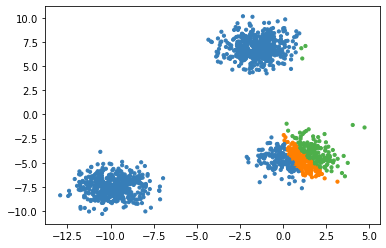

In [52]:
import matplotlib.pyplot as plt
from itertools import cycle, islice 

fig = plt.figure()      
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3',
                                    '#999999', '#e41a1c', '#dede00']),int(k))))
plt.scatter(x[:, 0], x[:, 1], s=10, color=colors[labelsPred.tolist()])
plt.show()
# plt.clf()